In [1]:
from IPython.display import display, HTML
import os
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%run ./nb_core/root_dirs.ipynb
setup_syspath_disentangle(False)
%run ./nb_core/disentangle_imports.ipynb

DATA_ROOT:	 /group/jug/ashesh/data/
CODE_ROOT:	 /home/ashesh.ashesh/


/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ckpt_dir = "/home/ashesh.ashesh/training/disentangle/2404/D25-M3-S0-L8/69"
assert os.path.exists(ckpt_dir)

In [4]:
def get_dtype(ckpt_fpath):
    if os.path.isdir(ckpt_fpath):
        ckpt_fpath = ckpt_fpath[:-1] if ckpt_fpath[-1] == '/' else ckpt_fpath
    elif os.path.isfile(ckpt_fpath):
        ckpt_fpath = os.path.dirname(ckpt_fpath)
    assert ckpt_fpath[-1] != '/'
    return int(ckpt_fpath.split('/')[-2].split('-')[0][1:])

In [5]:
dtype = get_dtype(ckpt_dir)
dtype

25

In [6]:
image_size_for_grid_centers = 32
mmse_count = 25
custom_image_size = None
data_t_list = None #[0]

save_comparative_plots =False
enable_calibration = True
batch_size = 64
num_workers = 4
COMPUTE_LOSS = False
use_deterministic_grid = None
threshold = None # 0.02
compute_kl_loss = False
evaluate_train = False# inspect training performance
eval_datasplit_type = DataSplitType.Val    
val_repeat_factor = None
psnr_type = 'range_invariant' #'simple', 'range_invariant'

In [7]:
%run ./nb_core/config_loader.ipynb

data:
  channel_idx_list:
  - 0
  - 1
  - 8
  channelwise_quantile: false
  clip_percentile: 1
  data_type: 25
  deterministic_grid: false
  dset_type: verylow
  enable_gaussian_noise: false
  grid_size: 32
  image_size: 64
  input_has_dependant_noise: true
  input_idx: 2
  input_is_sum: false
  multiscale_lowres_count: 3
  normalized_input: true
  num_channels: 3
  padding_mode: reflect
  padding_value: null
  poisson_noise_factor: -1
  randomized_channels: false
  sampler_type: 0
  synthetic_gaussian_scale: 100
  target_idx_list:
  - 0
  - 1
  target_separate_normalization: true
  threshold: 0.02
  train_aug_rotate: false
  trainig_datausage_fraction: 1.0
  use_one_mu_std: true
  val_grid_size: 32
datadir: /group/jug/ashesh/data/nikola_data/raw/
exptname: 2404/D25-M3-S0-L8/69
git:
  branch: lc_variant
  changedFiles:
  - disentangle/notebooks/datasets/nicola_dataset.ipynb
  latest_commit: 328e298eae7d2ba23e03b3b9918b5bdfc3094414
  untracked_files:
  - disentangle/notebooks/datasets/n

In [8]:
tokens = ckpt_dir.split('/')
idx = tokens.index('disentangle')
if config.model.model_type == 25 and tokens[idx+1] == '2312':
    config.model.model_type = ModelType.LadderVAERestrictedReconstruction

In [9]:
from disentangle.core.sampler_type import SamplerType
from disentangle.core.loss_type import LossType
from disentangle.data_loader.ht_iba1_ki67_rawdata_loader import SubDsetType
# from disentangle.core.lowres_merge_type import LowresMergeType


with config.unlocked():
    config.model.skip_nboundary_pixels_from_loss = None
    if config.model.model_type == ModelType.UNet and 'n_levels' not in config.model:
        config.model.n_levels = 4
    if config.data.sampler_type == SamplerType.NeighborSampler:
        config.data.sampler_type = SamplerType.DefaultSampler
        config.loss.loss_type = LossType.Elbo
        config.data.grid_size = config.data.image_size
    if 'ch1_fpath_list' in config.data:
        config.data.ch1_fpath_list = config.data.ch1_fpath_list[:1]
        config.data.mix_fpath_list = config.data.mix_fpath_list[:1]
    if config.data.data_type == DataType.Pavia2VanillaSplitting:
        if 'channel_2_downscale_factor' not in config.data:
            config.data.channel_2_downscale_factor = 1
    if config.model.model_type == ModelType.UNet and 'init_channel_count' not in config.model:
        config.model.init_channel_count = 64
    
    if 'skip_receptive_field_loss_tokens' not in config.loss:
        config.loss.skip_receptive_field_loss_tokens = []
    
    if dtype == DataType.HTIba1Ki67:
        config.data.subdset_type = SubDsetType.Iba1Ki64
        config.data.empty_patch_replacement_enabled = False
    
    if 'lowres_merge_type' not in config.model.encoder:
        config.model.encoder.lowres_merge_type = 0
    if 'validtarget_random_fraction' in config.data:
        config.data.validtarget_random_fraction = None
    
    if config.data.data_type == DataType.TwoDset:
        config.model.model_type = ModelType.LadderVae
        for key in config.data.dset1:
            config.data[key] = config.data.dset1[key]
    
    if 'dump_kth_frame_prediction' in config.training:
        config.training.dump_kth_frame_prediction = None

    if 'input_is_sum' not in config.data:
        config.data.input_is_sum = False

In [10]:
# config.data.channel_1 = 0 
# config.data.channel_2 = 3

In [11]:
dtype = config.data.data_type

if dtype in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve]:
    data_dir = f'{DATA_ROOT}/sinosoid_without_test/sinosoid/'
elif dtype == DataType.OptiMEM100_014:
    data_dir = f'{DATA_ROOT}/microscopy/'
elif dtype == DataType.Prevedel_EMBL:
    data_dir = f'{DATA_ROOT}/Prevedel_EMBL/PKG_3P_dualcolor_stacks/NoAverage_NoRegistration/'
elif dtype == DataType.AllenCellMito:
    data_dir = f'{DATA_ROOT}/allencell/2017_03_08_Struct_First_Pass_Seg/AICS-11/'
elif dtype == DataType.SeparateTiffData:
    data_dir = f'{DATA_ROOT}/ventura_gigascience'
elif dtype == DataType.SemiSupBloodVesselsEMBL:
    data_dir = f'{DATA_ROOT}/EMBL_halfsupervised/Demixing_3P'
elif dtype == DataType.Pavia2VanillaSplitting:
    data_dir = f'{DATA_ROOT}/pavia2'
elif dtype == DataType.ExpansionMicroscopyMitoTub:
    data_dir = f'{DATA_ROOT}/expansion_microscopy_Nick/'
elif dtype == DataType.ShroffMitoEr:
    data_dir = f'{DATA_ROOT}/shrofflab/'
elif dtype == DataType.HTIba1Ki67:
    data_dir = f'{DATA_ROOT}/Stefania/20230327_Ki67_and_Iba1_trainingdata/'
elif dtype == DataType.BioSR_MRC:
    data_dir = f'{DATA_ROOT}/BioSR/'
elif dtype == DataType.ExpMicroscopyV2:
    data_dir = f'{DATA_ROOT}/expansion_microscopy_v2/'
elif dtype == DataType.TavernaSox2GolgiV2:
    data_dir = f'{DATA_ROOT}/TavernaSox2Golgi/acquisition2/'
elif dtype == DataType.Pavia3SeqData:
    data_dir = f'{DATA_ROOT}/pavia3_sequential/'
elif dtype == DataType.NicolaData:
    data_dir = f'{DATA_ROOT}/nikola_data/raw'
elif dtype == DataType.Dao3ChannelWithInput:
    data_dir = f'{DATA_ROOT}/Dao4Channel/'
elif dtype == DataType.Dao3Channel:
    data_dir = f'{DATA_ROOT}/Dao3Channel/'

In [12]:
%run ./nb_core/disentangle_setup.ipynb


Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_14022025_verylowSNR.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_20022025_verylowSNR.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_20022025_001_verylowSNR.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False

[LCMultiChDloader] Train:1 Sz:64 N:46 NumPatchPerN:2500 Rot:False RandCrop:True Channel:3 Pad:{'mode': 'reflect'}
Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_14022025_verylowSNR.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_20022025_verylowSNR.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1

In [13]:
if config.data.multiscale_lowres_count is not None and custom_image_size is not None:
    model.reset_for_different_output_size(custom_image_size)

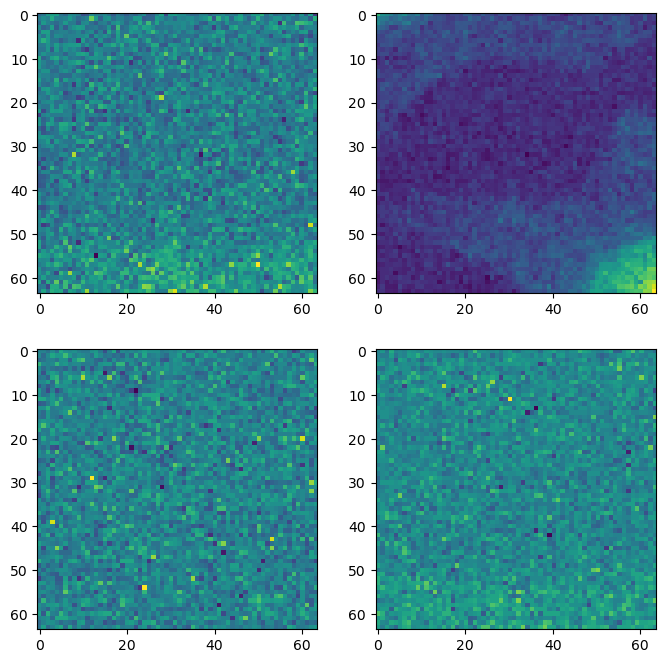

In [14]:
idx = np.random.randint(len(val_dset))
inp_tmp, tar_tmp, *_ = val_dset[idx]
ncols = len(tar_tmp)
nrows = 2
_,ax = plt.subplots(figsize=(4*ncols,4*nrows),ncols=ncols,nrows=nrows)
for i in range(min(ncols,len(inp_tmp))):
    ax[0,i].imshow(inp_tmp[i])

for channel_id in range(ncols):
    ax[1,channel_id].imshow(tar_tmp[channel_id])

In [15]:
if data_t_list is not None:
    val_dset.reduce_data(t_list=data_t_list)

In [16]:
# high val dset 
import ml_collections
new_config = ml_collections.ConfigDict(config)
if 'poisson_noise_factor' in new_config.data:
    new_config.data.poisson_noise_factor = -1
_, highsnr_val_dset = create_dataset(new_config, data_dir, eval_datasplit_type=eval_datasplit_type,
                                      kwargs_dict=dloader_kwargs)



Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_14022025_verylowSNR.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_20022025_verylowSNR.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_20022025_001_verylowSNR.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False

[LCMultiChDloader] Train:1 Sz:64 N:46 NumPatchPerN:2500 Rot:False RandCrop:True Channel:3 Pad:{'mode': 'reflect'}
Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_14022025_verylowSNR.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_20022025_verylowSNR.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 16

In [17]:
def get_full_input_frame(idx, dset):
    img_tuples, noise_tuples = dset._load_img(idx)
    if len(noise_tuples) > 0:
        factor = np.sqrt(2) if dset._input_is_sum else 1.0
        img_tuples = [x + noise_tuples[0] * factor for x in img_tuples]

    inp = 0
    for nch in img_tuples:
        inp += nch/len(img_tuples)
    h_start, w_start = dset._get_deterministic_hw(idx)
    return inp, h_start, w_start


In [18]:
index = np.random.randint(len(val_dset))
inp, tar = val_dset[index]
frame, h_start, w_start = get_full_input_frame(index, val_dset)
print(h_start, w_start)

912 560


In [19]:
from disentangle.core.tiff_reader import load_tiff
from disentangle.analysis.paper_plots import show_for_one, get_plotoutput_dir
def get_hwt_start(idx):
    h,w,t = val_dset.idx_manager.hwt_from_idx(idx, grid_size=64)
    print(h,w,t)
    pad = val_dset.per_side_overlap_pixelcount()
    h =  h - pad
    w = w - pad
    return h,w,t

def get_crop_from_fulldset_prediction(full_dset_pred, idx, patch_size=256):
    h,w,t = get_hwt_start(idx)
    return np.swapaxes(full_dset_pred[t,h:h+patch_size,w:w+patch_size].astype(np.float32)[None], 0, 3)[...,0]

if save_comparative_plots:
    assert eval_datasplit_type == DataSplitType.Test
    # CCP vs Microtubules: 925, 659, 502
    # hdn_usplitdata = load_tiff('/group/jug/ashesh/data/paper_stats/Test_PNone_G16_M3_Sk0/pred_disentangle_2402_D23-M3-S0-L0_67.tif')
    hdn_usplitdata = load_tiff('/group/jug/ashesh/data/paper_stats/Test_PNone_G32_M5_Sk0/pred_disentangle_2403_D23-M3-S0-L0_29.tif')

    # ER vs Microtubule 853, 859, 332
    # hdn_usplitdata = load_tiff('/group/jug/ashesh/data/paper_stats/Test_PNone_G16_M3_Sk0/pred_disentangle_2402_D23-M3-S0-L0_60.tif')

    #  ER vs CCP 327, 479, 637, 568
    # hdn_usplitdata = load_tiff('/group/jug/ashesh/data/paper_stats/Test_PNone_G16_M3_Sk0/pred_disentangle_2402_D23-M3-S0-L0_59.tif')

    #  F-actin vs ER 797
    # hdn_usplitdata = load_tiff('/group/jug/ashesh/data/paper_stats/Test_PNone_G32_M10_Sk0/pred_disentangle_2403_D23-M3-S0-L0_15.tif')

    idx = 10#np.random.randint(len(val_dset))
    patch_size = 500
    mmse_count = 50
    print(idx)
    show_for_one(idx, val_dset, highsnr_val_dset, model, None, mmse_count=mmse_count, patch_size=patch_size, baseline_preds=[
        get_crop_from_fulldset_prediction(hdn_usplitdata, idx).astype(np.float32),
    ], num_samples=0)


    plotsdir = get_plotoutput_dir(ckpt_dir, patch_size, mmse_count=mmse_count)
    model_id = ckpt_dir.strip('/').split('/')[-1]
    fname = f'patch_comparison_{idx}_{model_id}.png'
    fpath = os.path.join(plotsdir, fname)
    plt.savefig(fpath, dpi=200, bbox_inches='tight')
    print(f'Saved to {fpath}')

In [20]:
# from disentangle.data_loader.nikola_7D_rawdata_loader import *
# def load_one_fpath(fpath, channel_list):
#     data = load_7D(fpath)    
#     # data.shape: (1, 20, 1, 19, 1608, 1608, 1) 
#     data = data[0, :, 0, :, :, :, 0]
#     # data.shape: (20, 19, 1608, 1608)
#     # Here, 20 are different locations and 19 are different channels.
#     data = data[:, channel_list,...]
#     # swap the second and fourth axis
#     data = np.swapaxes(data[...,None], 1, 4)[:,0]
    
#     fname_prefix = '_'.join(os.path.basename(fpath).split('.')[0].split('_')[:-1])
#     if fname_prefix == 'uSplit_20022025_001':
#         data = np.delete(data, 2, axis=0)
#     elif fname_prefix == 'uSplit_14022025':
#         data = np.delete(data, [17, 19], axis=0)

#     # data.shape: (20, 1608, 1608, C)
#     return data

# ch_list = [NikolaChannelList.Ch_A, NikolaChannelList.Ch_B, NikolaChannelList.Ch_C, NikolaChannelList.Ch_D]
# data = load_one_fpath('/group/jug/ashesh/data/nikola_data/raw/uSplit_20022025_001_highSNR.nd2', ch_list)
# print(data.shape)
# data = data.astype(np.float32)
# _,ax = plt.subplots(figsize=(20,2),ncols=10)
# for i in range(10):
#     ax[i].imshow(data[i,::4,::4,0])

In [22]:
# from disentangle.analysis.paper_plots import show_for_one, get_plotoutput_dir
# idx = np.random.randint(len(val_dset))
# print(idx)
# patch_size = 256
# mmse_count = 50
# print(idx)
# show_for_one(idx, val_dset, val_dset, model, None, mmse_count=5, patch_size=patch_size, num_samples=2)


In [26]:
from disentangle.analysis.stitch_prediction import stitch_predictions
from disentangle.analysis.mmse_prediction import get_dset_predictions
# from disentangle.analysis.stitch_prediction import get_predictions as get_dset_predictions

pred_tiled, rec_loss, logvar_tiled, patch_psnr_tuple, pred_std_tiled = get_dset_predictions(model, val_dset,batch_size,
                                               num_workers=num_workers,
                                               mmse_count=mmse_count,
                                                model_type = config.model.model_type,
                                              )
tmp = np.round([x.item() for x in patch_psnr_tuple],2)
print('Patch wise PSNR, as computed during training', tmp,np.mean(tmp))

100%|██████████| 235/235 [32:46<00:00,  8.37s/it]


Patch wise PSNR, as computed during training [29.4  38.84] 34.120000000000005


In [27]:
pred_tiled.shape

(15000, 2, 64, 64)

In [28]:
idx_list = np.where(logvar_tiled.squeeze() < -6)[0]
if len(idx_list) > 0:
    plt.imshow(val_dset[idx_list[0]][1][1])

In [29]:
len(val_dset)

15000

In [30]:
print(np.quantile(rec_loss, [0,0.01,0.5, 0.9,0.99,0.999,1]).round(2))

[0.83 0.83 0.9  0.95 1.   1.01 1.01]


In [31]:
pred_tiled.shape

(15000, 2, 64, 64)

In [32]:
logvar_tiled.shape

(15000, 2, 64, 64)

In [33]:
if pred_tiled.shape[-1] != val_dset.get_img_sz():
    pad = (val_dset.get_img_sz() - pred_tiled.shape[-1] )//2
    pred_tiled = np.pad(pred_tiled, ((0,0),(0,0),(pad,pad),(pad,pad)))

pred = stitch_predictions(pred_tiled,val_dset, smoothening_pixelcount=0)
if len(np.unique(logvar_tiled)) == 1:
    logvar = None
else:
    logvar = stitch_predictions(logvar_tiled,val_dset, smoothening_pixelcount=0)
pred_std = stitch_predictions(pred_std_tiled,val_dset, smoothening_pixelcount=0)

In [34]:
if 'target_idx_list' in config.data and config.data.target_idx_list is not None:
    pred = pred[...,:len(config.data.target_idx_list)]
    pred_std = pred_std[...,:len(config.data.target_idx_list)]

In [35]:
def print_ignored_pixels():
    ignored_pixels = 1
    while(pred[0,-ignored_pixels:,-ignored_pixels:,].std() ==0):
        ignored_pixels+=1
    ignored_pixels-=1
    print(f'In {pred.shape}, last {ignored_pixels} many rows and columns are all zero.')
    return ignored_pixels

actual_ignored_pixels = print_ignored_pixels()

In (6, 1608, 1608, 2), last 8 many rows and columns are all zero.


## Ignore the pixels which are present in the last few rows and columns. 
1. They don't come in the batches. So, in prediction, they are simply zeros. So they are being are ignored right now. 
2. For the border pixels which are on the top and the left, overlapping yields worse performance. This is becuase, there is nothing to overlap on one side. So, they are essentially zero padded. This makes the performance worse. 

In [36]:
actual_ignored_pixels

8

In [37]:
if config.data.data_type in [DataType.OptiMEM100_014,
                                                      DataType.SemiSupBloodVesselsEMBL, 
                                                      DataType.Pavia2VanillaSplitting,
                                                      DataType.ExpansionMicroscopyMitoTub,
                                                      DataType.ShroffMitoEr,
                                                      DataType.HTIba1Ki67]:
    ignored_last_pixels = 32 
elif config.data.data_type == DataType.BioSR_MRC:
    ignored_last_pixels = 44
    # assert val_dset.get_img_sz() == 64
    # ignored_last_pixels = 108
elif config.data.data_type == DataType.NicolaData:
    ignored_last_pixels = 8
else:
    ignored_last_pixels = 0

ignore_first_pixels = 0
# ignored_last_pixels = 160
assert actual_ignored_pixels <= ignored_last_pixels, f'Set ignored_last_pixels={actual_ignored_pixels}'
print(ignored_last_pixels)

8


In [38]:
tar = val_dset._data
if 'target_idx_list' in config.data and config.data.target_idx_list is not None:
    tar = tar[...,config.data.target_idx_list]
def ignore_pixels(arr):
    if ignore_first_pixels:
        arr = arr[:,ignore_first_pixels:,ignore_first_pixels:]
    if ignored_last_pixels:
        arr = arr[:,:-ignored_last_pixels,:-ignored_last_pixels]
    return arr

pred = ignore_pixels(pred)
tar = ignore_pixels(tar)
if pred_std is not None:
    pred_std = ignore_pixels(pred_std)


In [39]:
ignored_last_pixels

8

In [40]:
# from disentangle.analysis.plot_utils import *
# def add_pixel_kde(ax,
#                   rect: List[float],
#                   data1: np.ndarray,
#                   data2: Union[np.ndarray, None],
#                   min_labelsize: int,
#                   color1='r',
#                   color2='black',
#                   color_xtick='white',
#                   label1='Target',
#                   label2='Predicted'):
#     """
#     Adds KDE (density plot) of data1(eg: target) and data2(ex: predicted) image pixel values as an inset
#     """
#     inset_ax = add_subplot_axes(ax, rect, facecolor="None", min_labelsize=min_labelsize)
    
#     inset_ax.tick_params(axis='x', colors=color_xtick)

#     sns.kdeplot(data=data1.reshape(-1, ), ax=inset_ax, color=color1, label=label1)
#     if data2 is not None:
#         sns.kdeplot(data=data2.reshape(-1, ), ax=inset_ax, color=color2, label=label2)
#     inset_ax.set_xlim(left=0)
#     xticks = inset_ax.get_xticks()
#     # inset_ax.set_xticks([xticks[0], xticks[-1]])
#     inset_ax.set_xticks([])
#     clean_for_xaxis_plot(inset_ax)


# ch1_pred_unnorm = pred[...,0]*sep_std[...,0].cpu().numpy() + sep_mean[...,0].cpu().numpy()
# ch2_pred_unnorm = pred[...,1]*sep_std[...,1].cpu().numpy() + sep_mean[...,1].cpu().numpy()

# inset_rect=[0.1,0.1,0.4,0.2]
# inset_min_labelsize=10
# color_ch_list=['goldenrod','cyan']

# _,ax = plt.subplots(figsize=(15,10),ncols=3,nrows=2)
# idx = 8
# pred1_crop  = ch1_pred_unnorm[idx,1116:1372,1064:1320].copy()
# pred2_crop  = ch2_pred_unnorm[idx,1116:1372,1064:1320].copy()
# pred1_crop[pred1_crop<0] = 0
# pred2_crop[pred2_crop<0] = 0

# tar1_crop   =  tar[idx,1116:1372,1064:1320,0]
# tar2_crop   =  tar[idx,1116:1372,1064:1320,1]

# ax[0,0].imshow(tar1_crop+tar2_crop)
# ax[0,1].imshow(tar1_crop)
# ax[0,2].imshow(tar2_crop)

# ax[1,0].imshow(pred1_crop+pred2_crop)
# ax[1,1].imshow(pred1_crop)
# ax[1,2].imshow(pred2_crop)
# clean_ax(ax)
# add_pixel_kde(ax[0,0], inset_rect, 
#               tar1_crop, 
#               tar2_crop, 
#               inset_min_labelsize,
#                 label1='Ch1', label2='Ch2', color1=color_ch_list[0], color2=color_ch_list[1])

# add_pixel_kde(ax[1,1], inset_rect, 
#               pred1_crop, 
#               tar1_crop, 
#               inset_min_labelsize,
#                 label1='Ch1', label2='Ch2', color1='red', color2=color_ch_list[0])
# add_pixel_kde(ax[1,2], inset_rect, 
#               pred2_crop, 
#               tar2_crop, 
#               inset_min_labelsize,
#                 label1='Ch1', label2='Ch2', color1='red', color2=color_ch_list[1])

In [41]:
from skimage.metrics import structural_similarity

def _avg_psnr(target, prediction, psnr_fn):
    output = np.mean([psnr_fn(target[i:i + 1], prediction[i:i + 1]).item() for i in range(len(prediction))])
    return round(output, 2)


def avg_range_inv_psnr(target, prediction):
    return _avg_psnr(target, prediction, RangeInvariantPsnr)


def avg_psnr(target, prediction):
    return _avg_psnr(target, prediction, PSNR)


def compute_masked_psnr(mask, tar1, tar2, pred1, pred2):
    mask = mask.astype(bool)
    mask = mask[..., 0]
    tmp_tar1 = tar1[mask].reshape((len(tar1), -1, 1))
    tmp_pred1 = pred1[mask].reshape((len(tar1), -1, 1))
    tmp_tar2 = tar2[mask].reshape((len(tar2), -1, 1))
    tmp_pred2 = pred2[mask].reshape((len(tar2), -1, 1))
    psnr1 = avg_range_inv_psnr(tmp_tar1, tmp_pred1)
    psnr2 = avg_range_inv_psnr(tmp_tar2, tmp_pred2)
    return psnr1, psnr2

def avg_ssim(target, prediction):
    ssim = [structural_similarity(target[i],prediction[i], data_range=(target[i].max() - target[i].min())) for i in range(len(target))]
    return np.mean(ssim),np.std(ssim)

In [42]:
sep_mean, sep_std = model.data_mean, model.data_std
if isinstance(sep_mean, dict):
    sep_mean = sep_mean['target']
    sep_std = sep_std['target']

if isinstance(sep_mean, int):
    pass
else:
    sep_mean = sep_mean.squeeze()[None,None,None]
    sep_std = sep_std.squeeze()[None,None,None]
    sep_mean = sep_mean.cpu().numpy() 
    sep_std = sep_std.cpu().numpy()

tar_normalized = (tar - sep_mean)/ sep_std

(6, 1600, 1600)
(6, 1600, 1600)


/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


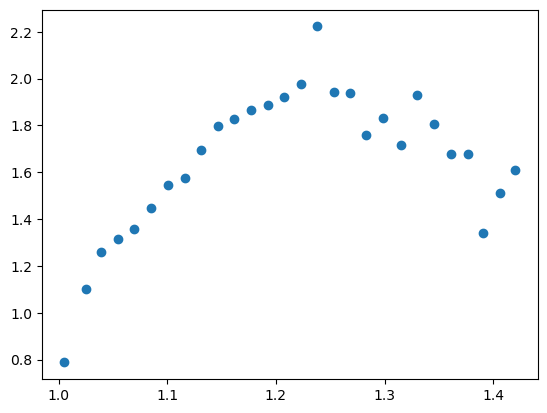

In [43]:
if enable_calibration:
    from disentangle.metrics.calibration import Calibration
    calib = Calibration(num_bins=30, mode='pixelwise')
    native_stats = calib.compute_stats(pred, pred_std, tar_normalized)
    count = np.array(native_stats[0]['bin_count'])
    count = count / count.sum()
    count.cumsum()[:-1]
    plt.plot(native_stats[0]['rmv'][1:-1], native_stats[0]['rmse'][1:-1], 'o')


/group/jug/ashesh/data/paper_figures/patch_64_mmse_50


nll: 17.40567684173584 scalar: 180.6085968017578:  71%|███████▏  | 2138/3000 [02:25<00:58, 14.69it/s]  

Epoch 02136: reducing learning rate of group 0 to 5.0000e-01.


nll: 18.450411224365233 scalar: 182.7384033203125:  83%|████████▎ | 2504/3000 [02:50<00:33, 14.75it/s] 

Epoch 02503: reducing learning rate of group 0 to 5.0000e-02.


nll: 17.778901481628417 scalar: 183.0972137451172: 100%|██████████| 3000/3000 [03:24<00:00, 14.66it/s] 
nll: 42.62616806030273 scalar: 178.41697692871094:  70%|██████▉   | 2098/3000 [02:23<01:01, 14.60it/s] 

Epoch 02096: reducing learning rate of group 0 to 5.0000e-01.


nll: 40.5002555847168 scalar: 180.86056518554688:  84%|████████▍ | 2516/3000 [02:51<00:33, 14.58it/s]  

Epoch 02514: reducing learning rate of group 0 to 5.0000e-02.


nll: 41.664542770385744 scalar: 180.9991912841797:  91%|█████████ | 2716/3000 [03:05<00:19, 14.58it/s] 

Epoch 02715: reducing learning rate of group 0 to 5.0000e-03.


nll: 40.78758010864258 scalar: 181.0210723876953: 100%|██████████| 3000/3000 [03:24<00:00, 14.68it/s]  


13.531341904819241 13.454407173402153
Saved calibration factor fitted on validation set to /group/jug/ashesh/data/paper_figures/patch_64_mmse_50/calibration_factor_2404_D25M3S0L8_69.npy
(6, 1600, 1600)
(6, 1600, 1600)


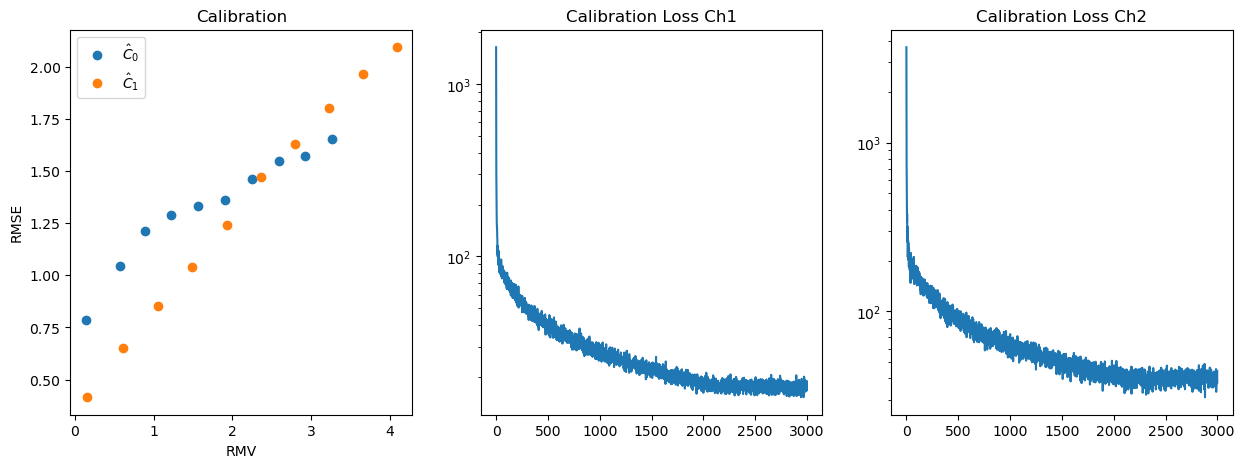

In [67]:
from disentangle.metrics.calibration import get_calibrated_factor_for_stdev
from disentangle.analysis.paper_plots import plot_calibration
import numpy as np

def get_plotoutput_dir(ckpt_dir, patch_size, mmse_count=50):
    plotsrootdir = f'/group/jug/ashesh/data/paper_figures/patch_{patch_size}_mmse_{mmse_count}'
    os.makedirs(plotsrootdir, exist_ok=True)
    print(plotsrootdir)
    return plotsrootdir

def get_calibration_fnames(ckpt_dir):
    tokens = ckpt_dir.strip('/').split('/')
    modelid = int(tokens[-1])
    model_specs = tokens[-2].replace('-','')
    monthyear = tokens[-3]
    fname_factor = f'calibration_factor_{monthyear}_{model_specs}_{modelid}.npy'
    fname_stats = f'calibration_stats_{monthyear}_{model_specs}_{modelid}.pkl.npy'
    return {'stats': fname_stats, 'factor': fname_factor}

def get_calibration_factor_fname(ckpt_dir):
    return get_calibration_fnames(ckpt_dir)['factor']

def get_calibration_stats_fname(ckpt_dir):
    return get_calibration_fnames(ckpt_dir)['stats']

if enable_calibration:
    inp, _ = val_dset[0]
    plotsdir = get_plotoutput_dir(ckpt_dir, inp.shape[1], mmse_count=mmse_count)
    fname = get_calibration_factor_fname(ckpt_dir)
    factor_fpath = os.path.join(plotsdir, fname)
    
    if eval_datasplit_type == DataSplitType.Val:
        epochs = 3000
        lr = 5.0
        calib_factor0, loss_arr0 = get_calibrated_factor_for_stdev(pred[...,0], np.log(pred_std[...,0]**2), tar_normalized[...,0], 
                                                        batch_size=8, lr=lr, epochs=epochs)
        calib_factor1, loss_arr1 = get_calibrated_factor_for_stdev(pred[...,1], np.log(pred_std[...,1]**2), tar_normalized[...,1], 
                                                        batch_size=8, lr=lr, epochs=epochs)
        print(calib_factor0, calib_factor1)
        calib_factor = np.array([calib_factor0, calib_factor1]).reshape(1,1,1,2)
        np.save(factor_fpath, calib_factor)
        print(f'Saved calibration factor fitted on validation set to {factor_fpath}')

    elif eval_datasplit_type == DataSplitType.Test:
        print('Loading the calibration factor from the file', factor_fpath)
        calib_factor = np.load(factor_fpath)

    calib = Calibration(num_bins=30, mode='pixelwise')
    stats = calib.compute_stats(pred, 2* np.log(pred_std * calib_factor), tar_normalized)

    # plot the calibration and the loss
    _,ax = plt.subplots(figsize=(15,5), ncols=3)
    plot_calibration(ax[0], stats)
    ax[1].plot(loss_arr0)
    ax[2].plot(loss_arr1)
    ax[1].set_yscale('log')
    ax[2].set_yscale('log')
    ax[0].set_title('Calibration')
    ax[1].set_title('Calibration Loss Ch1')
    ax[2].set_title('Calibration Loss Ch2')

if eval_datasplit_type == DataSplitType.Test:
    stats_fpath = os.path.join(plotsdir,get_calibration_stats_fname(ckpt_dir))
    np.save(stats_fpath, stats)
    print('Saved stats of Test set to ', stats_fpath)

In [ ]:
!ls -lhrt /group/jug/ashesh/data/paper_figures/patch_64_mmse_10/calibration_stats*

-rw-r--r-- 1 ashesh.ashesh jug 196M Apr 15 12:16 /group/jug/ashesh/data/paper_figures/patch_64_mmse_10/calibration_stats_2404_D25M3S0L8_29.pkl.npy
-rw-r--r-- 1 ashesh.ashesh jug 196M Apr 15 12:26 /group/jug/ashesh/data/paper_figures/patch_64_mmse_10/calibration_stats_2404_D25M3S0L8_32.pkl.npy
-rw-r--r-- 1 ashesh.ashesh jug 196M Apr 15 15:23 /group/jug/ashesh/data/paper_figures/patch_64_mmse_10/calibration_stats_2404_D25M3S0L8_30.pkl.npy


In [ ]:
break here

SyntaxError: invalid syntax (760050616.py, line 1)

### Calibration Plot

/group/jug/ashesh/data/paper_figures/patch_0_mmse_0
Saved to /group/jug/ashesh/data/paper_figures/patch_0_mmse_0/calibration_plot_30.png


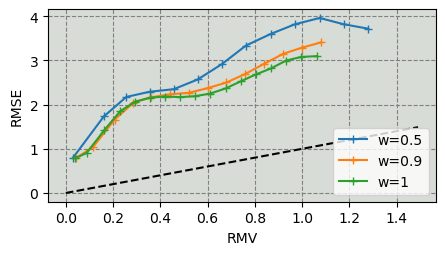

In [ ]:
from disentangle.analysis.paper_plots import get_first_index, get_last_index
calib_factors = [np.load(os.path.join('/group/jug/ashesh/data/paper_figures/patch_64_mmse_10/',fpath), allow_pickle=True) for fpath in [
                                                                 'calibration_stats_2404_D25M3S0L8_30.pkl.npy',
                                                                 'calibration_stats_2404_D25M3S0L8_29.pkl.npy',
                                                                 'calibration_stats_2404_D25M3S0L8_32.pkl.npy', 
                                                                 ]]
labels = ['w=0.5', 'w=0.9', 'w=1']

_,ax = plt.subplots(figsize=(5,2.5))
for i, calibration_stats in enumerate(calib_factors):
    first_idx = get_first_index(calibration_stats[()][0]['bin_count'], 0.0001)
    last_idx = get_last_index(calibration_stats[()][0]['bin_count'], 0.9999)
    ax.plot(calibration_stats[()][0]['rmv'][first_idx:-last_idx],
            calibration_stats[()][0]['rmse'][first_idx:-last_idx],
            '-+',
            label=labels[i])

ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.plot(np.arange(0,1.5, 0.01), np.arange(0,1.5, 0.01), 'k--')
ax.set_facecolor('xkcd:light grey')
plt.legend(loc='lower right')
# plt.xlim(0,3)
# plt.ylim(0,1.25)
plt.xlabel('RMV')
plt.ylabel('RMSE')
ax.set_axisbelow(True)


plotsdir = get_plotoutput_dir(ckpt_dir, 0, mmse_count=0)
model_id = ckpt_dir.strip('/').split('/')[-1]
fname = f'calibration_plot_{model_id}.png'
fpath = os.path.join(plotsdir, fname)
# plt.savefig(fpath, dpi=200, bbox_inches='tight')
print(f'Saved to {fpath}')


In [ ]:
q_vals = [0.01, 0.1,0.5,0.9,0.95, 0.99,1]
for i in range(tar_normalized.shape[-1]):
    print(f'Channel {i}:', np.quantile(tar_normalized[...,i], q_vals).round(2))

Channel 0: [-0.73 -0.62 -0.44  0.17  1.15  5.29 17.88]
Channel 1: [-0.53 -0.51 -0.47  1.63  2.85  6.61 38.34]
Channel 2: [-0.28 -0.27 -0.26 -0.17  2.01  5.01 20.75]


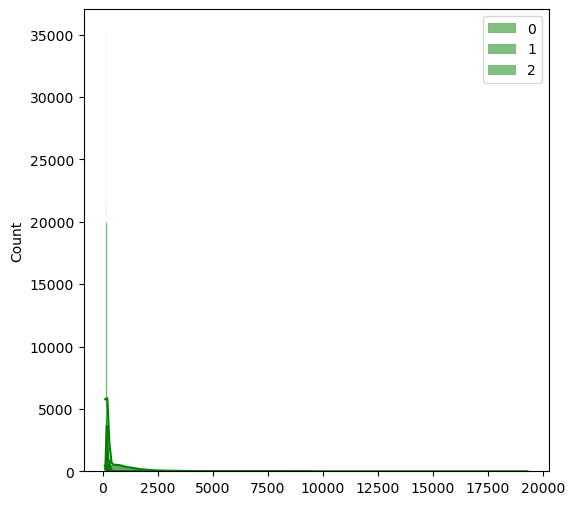

In [ ]:
_,ax = plt.subplots(figsize=(6,6))
for i in range(tar.shape[-1]):
    sns.histplot(tar[:,::10,::10,i].reshape(-1,), color='g', label=f'{i}', kde=True)

plt.legend()

In [ ]:
# from disentangle.data_loader.schroff_rawdata_loader import mito_channel_fnames
# from disentangle.core.tiff_reader import load_tiff
# import seaborn as sns

# fpaths = [os.path.join(datapath, x) for x in mito_channel_fnames()]
# fpath = fpaths[0]
# print(fpath)
# img = load_tiff(fpaths[0])
# temp = img.copy()
# sns.histplot(temp[:,:,::10,::10].reshape(-1,))
# plt.hist(temp[:,:,::10,::10].reshape(-1,),bins=100)

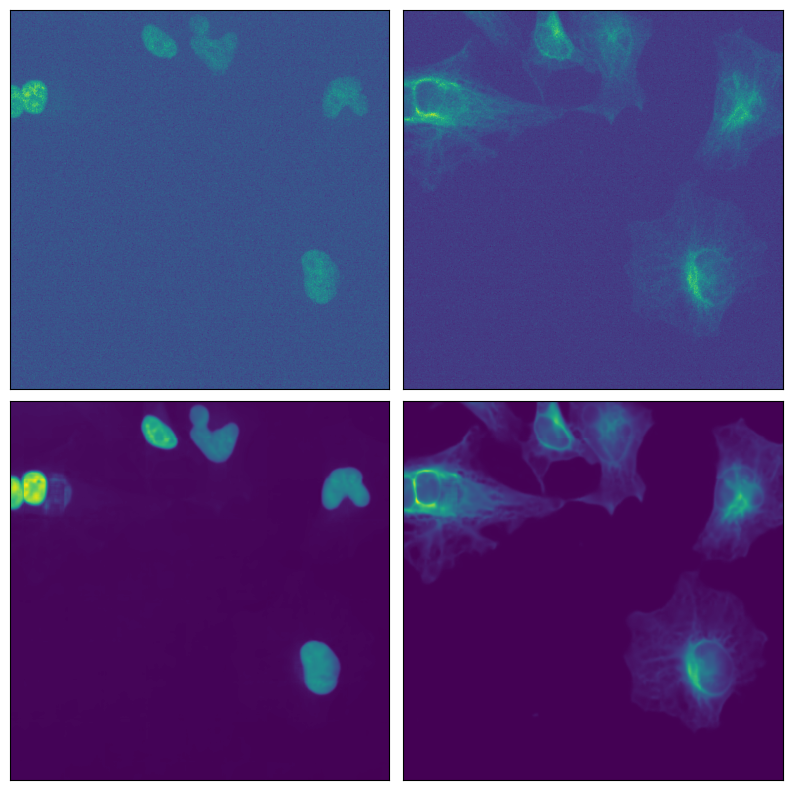

In [ ]:
ncols = tar.shape[-1]
_,ax = plt.subplots(figsize=(ncols*5,2*5),nrows=2,ncols=ncols)
img_idx = np.random.randint(len(tar))
sz = 600
hs = np.random.randint(tar.shape[1]-sz)
ws = np.random.randint(tar.shape[2]-sz)
for i in range(ncols):
    ax[0,i].imshow(tar[0,hs:hs+sz, ws:ws+sz ,i])
    ax[1,i].imshow(pred[0,hs:hs+sz, ws:ws+sz,i])
plt.subplots_adjust(wspace=0.03, hspace=0.03)

clean_ax(ax)


1


/home/ashesh.ashesh/code/Disentangle/disentangle/analysis/plot_error_utils.py:52: UserWarning: Overwriting the cmap 'shiftedcmap' that was already in the registry.
  matplotlib.colormaps.register(cmap=newcmap, force=True)


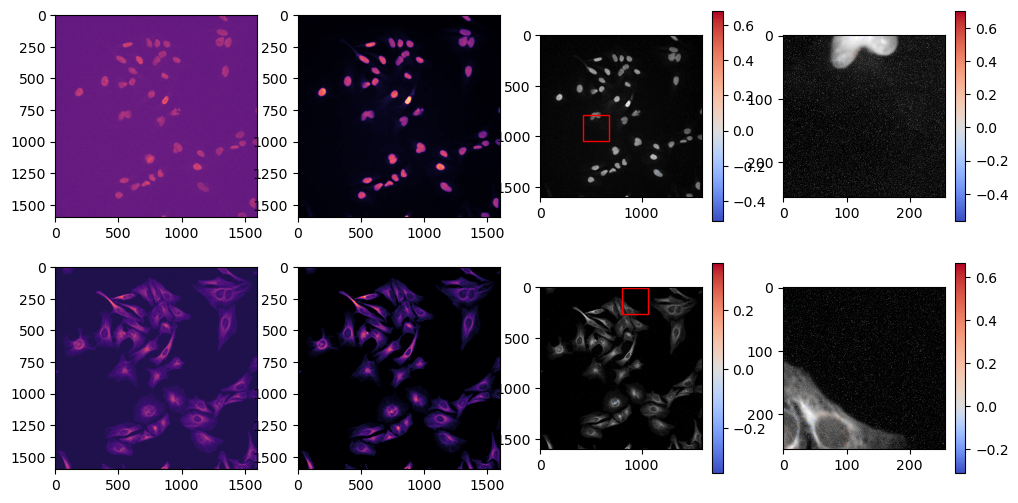

In [ ]:
import matplotlib.patches as patches
import matplotlib
from disentangle.analysis.plot_error_utils import plot_error
nrows = pred.shape[-1]
img_sz = 3
_,ax = plt.subplots(figsize=(4*img_sz,nrows*img_sz),ncols=4,nrows=nrows)
idx = np.random.randint(len(pred))
print(idx)
for ch_id in range(nrows):
  ax[ch_id,0].imshow(tar_normalized[idx,..., ch_id], cmap='magma')
  ax[ch_id,1].imshow(pred[idx,:,:,ch_id], cmap='magma')
  plot_error(tar_normalized[idx,...,ch_id], 
            pred[idx,:,:,ch_id], 
            cmap = matplotlib.cm.coolwarm, 
            ax = ax[ch_id,2], max_val = None)

  cropsz = 256
  h_s = np.random.randint(0, tar_normalized.shape[1] - cropsz)
  h_e = h_s + cropsz
  w_s = np.random.randint(0, tar_normalized.shape[2] - cropsz)
  w_e = w_s + cropsz

  plot_error(tar_normalized[idx,h_s:h_e,w_s:w_e, ch_id], 
            pred[idx,h_s:h_e,w_s:w_e,ch_id], 
            cmap = matplotlib.cm.coolwarm, 
            ax = ax[ch_id,3], max_val = None)

  # Add rectangle to the region
  rect = patches.Rectangle((w_s, h_s), w_e-w_s, h_e-h_s, linewidth=1, edgecolor='r', facecolor='none')
  ax[ch_id,2].add_patch(rect)


In [ ]:
# ch1_pred_unnorm = pred[...,0]*sep_std[...,0].cpu().numpy() + sep_mean[...,0].cpu().numpy()
# ch2_pred_unnorm = pred[...,1]*sep_std[...,1].cpu().numpy() + sep_mean[...,1].cpu().numpy()
pred_unnorm = []
for i in range(pred.shape[-1]):
    if sep_std.shape[-1]==1:
        temp_pred_unnorm = pred[...,i]*sep_std[...,0] + sep_mean[...,0]
    else:
        temp_pred_unnorm = pred[...,i]*sep_std[...,i] + sep_mean[...,i]
    pred_unnorm.append(temp_pred_unnorm)

In [ ]:
from disentangle.scripts.evaluate import get_highsnr_data
highres_data = None
highres_data = get_highsnr_data(config, data_dir, eval_datasplit_type)
if highres_data is not None:
    highres_data = ignore_pixels(highres_data).copy()
    if data_t_list is not None:
        highres_data = highres_data[data_t_list].copy()
    
    if 'target_idx_list' in config.data and config.data.target_idx_list is not None:
        highres_data = highres_data[...,config.data.target_idx_list]


Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_14022025_highSNR.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_20022025_highSNR.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_20022025_001_highSNR.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_14022025_highSNR.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_20022025_highSNR.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from /group/jug/ashesh/data//nikola_data/raw/uSplit_20022025_001_highSNR.

In [ ]:
from disentangle.scripts.evaluate import compute_multiscale_ssim
if highres_data is not None:
    print(f'{DataSplitType.name(eval_datasplit_type)}_P{custom_image_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignored_last_pixels}')
    psnr_list = [avg_range_inv_psnr(highres_data[...,k], pred_unnorm[k]) for k in range(len(pred_unnorm))]
    tar_tmp = (highres_data - sep_mean) /sep_std
    # tar0_tmp = (highres_data[...,0] - sep_mean[...,0]) /sep_std[...,0]
    ssim_list = compute_multiscale_ssim(tar_tmp, pred, range_invariant=False )
    rims_ssim_list = compute_multiscale_ssim(tar_tmp, pred, range_invariant=True )
    # ssim1_hres_mean, ssim1_hres_std = avg_ssim(highres_data[...,0], pred_unnorm[0])
    # ssim2_hres_mean, ssim2_hres_std = avg_ssim(highres_data[...,1], pred_unnorm[1])
    print('PSNR on Highres', ' '.join([str(x) for x in psnr_list]))
    print('Multiscale SSIM on Highres', [np.round(ssim, 3) for ssim in ssim_list])
    print('Range Invariant Multiscale SSIM on Highres', [np.round(ssim, 3) for ssim in rims_ssim_list])



Test_PNone_G64_M10_Sk8
PSNR on Highres 28.36 29.0
Multiscale SSIM on Highres [0.698, 0.833]
Range Invariant Multiscale SSIM on Highres [0.953, 0.946]


In [ ]:
eps = 0.1
if config.model.model_type == ModelType.DenoiserSplitter:
    ch_idx = 0
    def predict(inp):
        inp = model.denoise_one_channel(inp, model._denoiser_input)
        out = model(inp)[0]
        return model.likelihood.distr_params(out)['mean'].cpu().numpy()

    idx = np.random.randint(0, len(val_dset))
    inp_tmp, tar_tmp = val_dset[idx]
    h,w,t = val_dset.idx_manager.hwt_from_idx(idx)
    h -= val_dset.per_side_overlap_pixelcount()
    w -= val_dset.per_side_overlap_pixelcount()
    print(idx)
    inp_tmp = torch.Tensor(inp_tmp[None]).cuda()

    with torch.no_grad():
        clean_pred1 = predict(inp_tmp)
        clean_pred2 = predict(inp_tmp)
        clean_pred3 = predict(inp_tmp)
        pred_mmse_arr = []
        for _ in range(50):
            clean_pred4 = predict(inp_tmp)
            pred_mmse_arr.append(clean_pred4)
        pred_mmse = np.mean(pred_mmse_arr, axis=0, keepdims=False)

    _,ax = plt.subplots(ncols=6, figsize=(18,3))
    ax[0].imshow(inp_tmp[0,0].cpu().numpy() ,cmap='magma')
    ax[1].imshow(highres_data[t,h:h+256,w:w+256,ch_idx] , cmap='magma')
    ax[2].imshow(clean_pred1[0,ch_idx], cmap='magma')
    ax[3].imshow(clean_pred2[0,ch_idx], cmap='magma')
    ax[4].imshow(pred_mmse[0,ch_idx], cmap='magma')
    ax[5].imshow(np.std(pred_mmse_arr, axis=0, keepdims=False)[0,ch_idx]/(eps + np.abs(pred_mmse[0,ch_idx])), cmap='magma')
    unnorm_temp_pred = (pred_mmse* data_std + data_mean)
    minv = unnorm_temp_pred[0,ch_idx].min()
    maxv = unnorm_temp_pred[0,ch_idx].max()
    print(minv, maxv)

In [ ]:
rmse_arr = []
psnr_arr = []
rinv_psnr_arr = []
ssim_arr = []
for ch_id in range(pred.shape[-1]):
    rmse =np.sqrt(((pred[...,ch_id] - tar_normalized[...,ch_id])**2).reshape(len(pred),-1).mean(axis=1))
    rmse_arr.append(rmse)
    psnr = avg_psnr(tar_normalized[...,ch_id].copy(), pred[...,ch_id].copy()) 
    rinv_psnr = avg_range_inv_psnr(tar_normalized[...,ch_id].copy(), pred[...,ch_id].copy())
    ssim_mean, ssim_std = avg_ssim(tar[...,ch_id], pred_unnorm[ch_id])
    psnr_arr.append(psnr)
    rinv_psnr_arr.append(rinv_psnr)
    ssim_arr.append((ssim_mean,ssim_std))


In [ ]:
print(f'{DataSplitType.name(eval_datasplit_type)}_P{custom_image_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignored_last_pixels}')
print('Rec Loss',np.round(rec_loss.mean(),3) )
print('RMSE', '\t'.join([str(np.mean(x).round(3)) for x in rmse_arr]))
print('PSNR', '\t'.join([str(x) for x in psnr_arr]))
print('RangeInvPSNR','\t'.join([str(x) for x in rinv_psnr_arr]))
print('SSIM','\t'.join([f'{round(x,3)}±{round(y,4)}' for (x,y) in ssim_arr]))
print()

Test_PNone_G32_M1_Sk8
Rec Loss 3.371
RMSE 14.001	1.57
PSNR 12.48	23.54
RangeInvPSNR 19.72	28.22
SSIM 0.491±0.218	0.93±0.0388



In [ ]:
if config.model.model_type == ModelType.LadderVaeSemiSupervised:
    from disentangle.analysis.plot_utils import add_pixel_kde
    inset_rect=[0.1,0.1,0.4,0.2]
    min_labelsize = 15

    nimgs=5
    crp_sz = 400
    img_sz = 8

    _,ax = plt.subplots(figsize=(4*img_sz,img_sz*nimgs),ncols=5,nrows=nimgs)
    clean_ax(ax[1:,])
    clean_ax(ax[:,1:])
    img_idx_list = np.random.permutation(np.arange(len(tar1)))[:nimgs] #[19,23,15,18,4] # 
    for ax_idx in range(nimgs):
        img_idx = img_idx_list[ax_idx]
        overlapping_pred = pred1[img_idx] + pred2[img_idx]
        overlapping_min = min(tar1[img_idx].min(),overlapping_pred.min())
        overlapping_max = max(tar1[img_idx].max(),overlapping_pred.max())

        ax[ax_idx,0].imshow(tar1[img_idx])#,vmin=overlapping_min,vmax=overlapping_max)
        ax[ax_idx,1].imshow(overlapping_pred)#,vmin=overlapping_min,vmax=overlapping_max)

        ch1_min = tar2[img_idx].min()#,pred1[img_idx].min())
        ch1_max = tar2[img_idx].max()#,pred1[img_idx].max())
        ax[ax_idx,2].imshow(tar2[img_idx])#,vmin=ch1_min,vmax=ch1_max)
        ax[ax_idx,3].imshow(pred1[img_idx])#,vmin=ch1_min,vmax=ch1_max)

        ax[ax_idx,4].imshow(pred2[img_idx])
        ax[ax_idx,0].set_ylabel(f'{img_idx}',fontsize=min_labelsize)

        # add_pixel_kde(ax[ax_idx,1],
        #               inset_rect,
        #               tar1 [img_idx],
        #               data2 =overlapping_pred,
        #              min_labelsize=min_labelsize)
        
        # add_pixel_kde(ax[ax_idx,3],
        #               inset_rect,
        #               tar2 [img_idx],
        #               data2 =pred1[img_idx],
        #              min_labelsize=min_labelsize)
        

    ax[0,0].set_title('Inp')
    ax[0,1].set_title('Recons')
    ax[0,2].set_title('GT 1')
    ax[0,3].set_title('Pred 1')
    ax[0,4].set_title('Pred 2')

#

### To save to tiff file.

In [ ]:
# ch1_pred_unnorm = pred[...,0]*sep_std[...,1].cpu().numpy() + sep_mean[...,1].cpu().numpy()
# input_pred_unnorm = pred[...,2]*sep_std[...,0].cpu().numpy() + sep_mean[...,0].cpu().numpy()
# ch2_pred_unnorm = input_pred_unnorm - ch1_pred_unnorm
# ch2_pred_unnorm = pred[...,1]*sep_std[...,1].cpu().numpy() + sep_mean[...,1].cpu().numpy() #ch2_pred_unnorm - ch2_pred_unnorm.min()

# ch1_pred_unnorm = ch1_pred_unnorm.astype(np.int32)
# input_pred_unnorm = input_pred_unnorm.astype(np.int32)
# ch2_pred_unnorm = ch2_pred_unnorm.astype(np.int32)

# data = np.concatenate([val_dset._data[:,:480,:480], ch1_pred_unnorm[...,None],
# ch2_pred_unnorm[...,None], input_pred_unnorm[...,None]],
# axis=-1)

# import tifffile
# tifffile.imwrite("prediction2.tif", 
# np.swapaxes(data[:,None],1,4)[...,0].astype(np.uint16),
# imagej=True, 
# #  metadata={ 'axes': 'ZYXC'}, 
#  )

(2, 1608, 1608, 3)

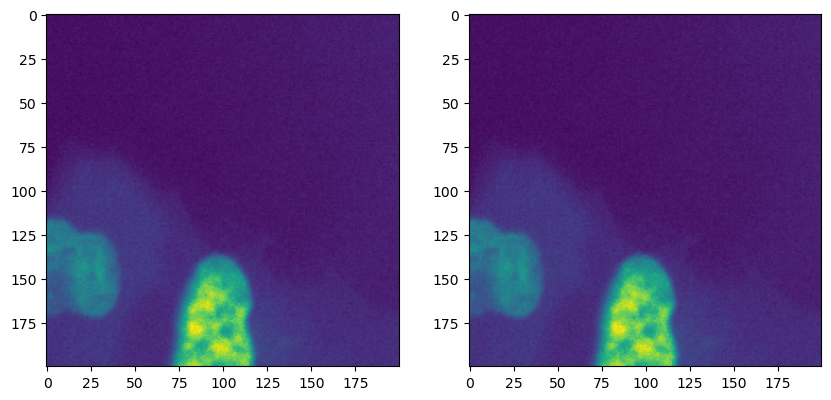

In [ ]:
_, ax  = plt.subplots(figsize=(10,5),ncols=2)
ax[0].imshow(highsnr_val_dset._data[0,:200,:200,0])
ax[1].imshow(val_dset._data[0,:200,:200,0])
highsnr_val_dset._data.shape

In [ ]:
break here

SyntaxError: invalid syntax (760050616.py, line 1)

In [ ]:
from disentangle.analysis.paper_plots import show_for_one
# # show_for_one(np.random.randint(len(val_dset)), mmse_count=50, patch_size=256)
# # show_for_one(899, mmse_count=50, patch_size=256)
# # show_for_one(51, mmse_count=50, patch_size=256)
# # # show_for_one(352, mmse_count=50, patch_size=256)
# # show_for_one(872, mmse_count=50, patch_size=256)
# # show_for_one(552, mmse_count=50, patch_size=256)
# 656, 327, 612, 490
# 51, 899, 352, 872, 552 ER vs Microtubules (144)
# 716, 599, 173 CCP vs Microtubules (145)
#  703, 189, 423 ER vs CCP (143)
# 772, 694, 237. Adverse:630 F-actin vs Er 
idx = 716
patch_size = 64
mmse_count = 5
print(idx)
# fname = f'patch_comparison_{idx}.png'
# show_for_one(idx, val_dset, highsnr_val_dset, model, None, mmse_count=mmse_count, patch_size=patch_size, baseline_preds=[
#     get_crop_from_fulldset_prediction(hdn_usplitdata, idx).astype(np.float32),
# ], num_samples=0)

show_for_one(idx, val_dset, highsnr_val_dset, model, None, mmse_count=mmse_count, patch_size=patch_size, num_samples=2)

plotsdir = get_plotoutput_dir(ckpt_dir, patch_size, mmse_count=mmse_count)
model_id = ckpt_dir.strip('/').split('/')[-1]
fname = f'sampling_figure_{idx}_{model_id}.png'
fpath = os.path.join(plotsdir, fname)
# plt.savefig(fpath, dpi=200, bbox_inches='tight')
print(f'Saved to {fpath}')

716
Predicting for 716


RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

In [ ]:
break here

## Creating tiff file

In [ ]:
from disentangle.analysis.paper_plots import get_plotoutput_dir, get_predictions
patch_size = 256
mmse_count = 50
idx_list = [51, 899, 352, 872, 552, 841] # Tub vs MT


plotsdir = get_plotoutput_dir(ckpt_dir, patch_size, mmse_count=mmse_count)
for idx in idx_list:
    inp, tar, tar_hsnr, recon_img_list = get_predictions(idx, val_dset, model, mmse_count=mmse_count, patch_size=patch_size)
    highsnr_val_dset.set_img_sz(patch_size, 64)
    highsnr_val_dset.disable_noise()
    _, tar_hsnr = highsnr_val_dset[idx]
    plotfpath = os.path.join(plotsdir, f'{idx}.npy')
    np.save(plotfpath, {'inp':inp, 'tar':tar, 'tar_hsnr':tar_hsnr, 'recon_img_list':recon_img_list})
    print(f'Generated {plotfpath}')

In [ ]:
ddict = np.load('/group/jug/ashesh/data/paper_figures/patch_256_mmse_50/2402-D16M3S0-150/841.npy', allow_pickle=True)
plt.imshow(ddict[()]['inp'][0,0].cpu().numpy())

In [ ]:
plot_crops(ddict[()]['inp'], ddict[()]['tar'], ddict[()]['tar_hsnr'], ddict[()]['recon_img_list'])


In [ ]:
from skimage.io import imsave
import numpy as np
pred_unnorm = np.concatenate([ch1_pred_unnorm[...,None],
                              ch2_pred_unnorm[...,None]],
                              axis=-1)
for ch_idx in [0,1]:
    tif_fname = f'{fname_prefix}_P{custom_image_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignored_last_pixels}_C{ch_idx}.tif'
    tif_fpath=os.path.join('paper_tifs',tif_fname)
    if config.data.data_type in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve]:
        output = np.concatenate([
                            pred_unnorm[None,:50,...,ch_idx],tar[None,:50,...,ch_idx],
        ],axis=0)
    else:
        output = np.concatenate([
                                pred_unnorm[:1,...,ch_idx],tar[:1,...,ch_idx],
        ],axis=0)
    imsave(tif_fpath,output,plugin='tifffile')
    print(tif_fpath)

In [ ]:
! ls -lhrt paper_tifs/2211-D8M3S0-*

In [ ]:
# !ls paper_tifs/2211-D3M3S0-0_P64_G*

In [ ]:
idx = np.random.randint(len(val_dset))
inp, tar = val_dset[idx]

In [ ]:
if len(inp) > 1:
    _,ax = plt.subplots(figsize=(10,2.5),ncols=4)
    ax[0].imshow(inp[0])
    ax[1].imshow(inp[1])
    ax[2].imshow(inp[2])
    ax[3].imshow(inp[3])

In [ ]:
tar_unnorm.shape

In [ ]:
# _,ax = plt.subplots(figsize=(10,10))
# tmp_data =tar_unnorm[idx,:,:,1]
# q = np.quantile(tmp_data,0.95)
# tmp_data[tmp_data >q] = q
# plt.imshow(tmp_data)

In [ ]:
pred_unnorm.min()

In [ ]:
idx =  np.random.randint(len(tar_unnorm))
print(idx)
_,ax = plt.subplots(figsize=(20,20),ncols=2,nrows=2)
ax[0,0].set_title('Channel 1',size=20)
ax[0,1].set_title('Channel 2',size=20)
ax[0,0].set_ylabel('Target',size=20)
ax[1,0].set_ylabel('Predictions',size=20)
ax[0,0].imshow(tar_unnorm[idx,:,:,0])
ax[0,1].imshow(tar_unnorm[idx,:,:,1])
ax[1,0].imshow(pred_unnorm[idx,:,:,0])
ax[1,1].imshow(pred_unnorm[idx,:,:,1])

In [ ]:
idx =  0#np.random.randint(len(tar_unnorm))
print(idx)
_,ax = plt.subplots(figsize=(20,30),ncols=2,nrows=3)
ax[0,0].set_title('Target',size=20)
ax[0,1].set_title('Prediction',size=20)
ax[0,0].set_ylabel('Mixed Input',size=20)
ax[1,0].set_ylabel('Channel 1',size=20)
ax[2,0].set_ylabel('Channel 2',size=20)
sz = 400
ax[0,0].imshow(np.mean(tar_unnorm[idx, 1000:1000+sz,400:400+sz], axis=2))
ax[0,1].imshow(np.mean(pred_unnorm[idx,1000:1000+sz,400:400+sz], axis=2))

ax[1,0].imshow(tar_unnorm[idx, 1000:1000+sz,400:400+sz,0],vmax=126,vmin=88)
ax[1,1].imshow(pred_unnorm[idx,1000:1000+sz,400:400+sz,0], vmax=126,vmin=88)

ax[2,0].imshow(tar_unnorm[idx, 1000:1000+sz,400:400+sz,1],vmax=126,vmin=78)
ax[2,1].imshow(pred_unnorm[idx,1000:1000+sz,400:400+sz,1],vmax=126,vmin=78)

In [ ]:
tar_unnorm[idx, 1000:1500,400:900,0].std()

In [ ]:
pred_unnorm[idx,1000:1500,400:900,0].std()

In [ ]:
idx =  np.random.randint(len(tar_unnorm))
print(idx)
_,ax = plt.subplots(figsize=(20,30),ncols=2,nrows=3)
ax[0,0].set_title('Target',size=20)
ax[0,1].set_title('Prediction',size=20)
ax[0,0].set_ylabel('Mixed Input',size=20)
ax[1,0].set_ylabel('Channel 1',size=20)
ax[2,0].set_ylabel('Channel 2',size=20)

ax[0,0].imshow(np.mean(tar_unnorm[idx, 1000:1500,400:900], axis=2))
ax[0,1].imshow(np.mean(pred_unnorm[idx,1000:1500,400:900], axis=2))

ax[1,0].imshow(tar_unnorm[idx, 1000:1500,400:900,0])
ax[1,1].imshow(pred_unnorm[idx,1000:1500,400:900,0])

ax[2,0].imshow(tar_unnorm[idx, 1000:1500,400:900,1])
ax[2,1].imshow(pred_unnorm[idx,1000:1500,400:900,1])

In [ ]:
break here

## Comparing PSNR with high res data. 

In [ ]:
from disentangle.core.data_split_type import  get_datasplit_tuples

In [ ]:
if eval_datasplit_type == DataSplitType.Val:
    N = len(pred1)/config.training.val_fraction
elif eval_datasplit_type == DataSplitType.Test:
    N = len(pred1)/config.training.test_fraction
train_idx,val_idx,test_idx = get_datasplit_tuples(config.training.val_fraction,config.training.test_fraction,N,
                                          starting_train=False)

In [ ]:
from disentangle.core.tiff_reader import load_tiff

In [ ]:
highres_actin = load_tiff('/home/ashesh.ashesh/data/ventura_gigascience/actin-60x-noise2-highsnr.tif')[...,None]
highres_mito = load_tiff('/home/ashesh.ashesh/data/ventura_gigascience/mito-60x-noise2-highsnr.tif')[...,None]

if eval_datasplit_type == DataSplitType.Val:
    highres_data = np.concatenate([highres_actin[val_idx[0]:val_idx[1]],
                                   highres_mito[val_idx[0]:val_idx[1]]],
                                  axis=-1).astype(np.float32)
elif eval_datasplit_type == DataSplitType.Test:
    highres_data = np.concatenate([highres_actin[test_idx[0]:test_idx[1]],
                                   highres_mito[test_idx[0]:test_idx[1]]],
                                  axis=-1).astype(np.float32)

In [ ]:
thresh = np.quantile(highres_data,config.data.clip_percentile)
highres_data[highres_data > thresh]=thresh
    

In [ ]:
_,ax = plt.subplots(figsize=(8,8),ncols=2,nrows=2)
ax[0,0].imshow(tar_unnorm[5,...,0])
ax[0,1].imshow(highres_data[5,...,0])
ax[1,0].imshow(tar_unnorm[8,...,1])
ax[1,1].imshow(highres_data[8,...,1])


In [ ]:
print('PSNR with HighRes', avg_psnr(highres_data[...,0], pred1),avg_psnr(highres_data[...,1], pred2))
print('RangeInvPSNR with HighRes', avg_range_inv_psnr(highres_data[...,0], pred1), 
      avg_range_inv_psnr(highres_data[...,1], pred2))


In [ ]:
# RangeInvPSNR with HighRes 16.82 18.33


In [ ]:
tar_1_tmp.dtype

In [ ]:
from disentangle.core.psnr import fix_range, zero_mean
def fix_range_with_highresdata(pred,tar):
    pred_1_tmp = torch.Tensor(pred.reshape(len(pred),-1))
    tar_1_tmp = torch.Tensor(tar.reshape(len(tar),-1))
    pred_1_tmp = zero_mean(pred_1_tmp)
    tar_1_tmp = zero_mean(tar_1_tmp)
#     import pdb;pdb.set_trace()
    tar_1_tmp = tar_1_tmp / torch.std(tar_1_tmp, dim=1, keepdim=True)
    
    pred_1_tmp = fix_range(tar_1_tmp,pred_1_tmp)
    pred_1_tmp = pred_1_tmp.reshape_as(torch.Tensor(pred))
    tar_1_tmp = tar_1_tmp.reshape_as(torch.Tensor(pred))
    return pred_1_tmp, tar_1_tmp

In [ ]:
pred1_tmp, tar1_tmp = fix_range_with_highresdata(pred1, highres_data[...,0])
pred2_tmp, tar2_tmp = fix_range_with_highresdata(pred2, highres_data[...,1])

In [ ]:
ssim1_mean, ssim1_std = avg_ssim(tar1_tmp.numpy(), pred1_tmp.numpy())
ssim2_mean, ssim2_std = avg_ssim(tar2_tmp.numpy(), pred2_tmp.numpy())
print(ssim1_mean, ssim2_mean)

In [ ]:
_,ax = plt.subplots(figsize=(8,4),ncols=2)
ax[0].imshow(pred_1_tmp[0])
ax[1].imshow(tar_1_tmp[0])


In [ ]:
break here.

## Inspecting the performance on grid boundaries.


In [ ]:
from disentangle.analysis.stitch_prediction import stitched_prediction_mask


skip_boundary_pixel_count = 0
for sk_c in [1,16,32,48,56]:
    mask = stitched_prediction_mask(val_dset, 
                                (val_dset._img_sz,val_dset._img_sz), 
                                skip_boundary_pixel_count, 
                                sk_c)
    mask = ignore_pixels(mask)
    psnr1, psnr2 = compute_masked_psnr(mask, tar1,tar2,pred1,pred2)
    print(f'[Pad:{val_dset.per_side_overlap_pixelcount()}] SkipCentral', sk_c,
          psnr1,psnr2)

In [ ]:
plt.imshow(mask[0,:,:,0])

## Inspecting the performance on central regions

In [ ]:
skip_central_pixel_count = 0

for sk_b in [1,8,16,20,24]:
    mask = stitched_prediction_mask(val_dset, 
                                (val_dset._img_sz,val_dset._img_sz), 
                                sk_b, 
                                skip_central_pixel_count)
    mask = ignore_pixels(mask)
    psnr1, psnr2 = compute_masked_psnr(mask, tar1,tar2,pred1,pred2)
    print(f'[Pad:{val_dset.per_side_overlap_pixelcount()}] SkipBoundary', sk_b, psnr1,psnr2)

In [ ]:
plt.imshow(mask[0,:,:,0])

In [ ]:
# for w in range(2,202,25):
#     print(f'RangeInvPSNR but skipping {w}', avg_range_inv_psnr(np.copy(tar1[:,w:-w,w:-w]), 
#                                                                np.copy(pred1[:,w:-w,w:-w])),
    
#                                             avg_range_inv_psnr(np.copy(tar2[:,w:-w,w:-w]), 
#                                                                np.copy(pred2[:,w:-w,w:-w]).copy()))

In [ ]:
h = 1200
w = 1200
sz = 512
x = tar_unnorm[:1,h:h+sz,w:w+sz].mean(axis=3)

In [ ]:
p_count = 32
y1 = np.pad(x,np.array([[0, 0], [p_count, p_count], [p_count, p_count]]))
y2 = np.pad(x,np.array([[0, 0], [p_count, p_count], [p_count, p_count]]), constant_values=237)
y3 = np.pad(x,np.array([[0, 0], [p_count, p_count], [p_count, p_count]]), mode='linear_ramp', end_values=237)
y4 = np.pad(x,np.array([[0, 0], [p_count, p_count], [p_count, p_count]]),mode='reflect')


In [ ]:
np.quantile(x, [0,0.05, 0.1])

In [ ]:
_,ax = plt.subplots(figsize=(16,4),ncols=4)
ax[0].imshow(y1[0], )
ax[1].imshow(y2[0], )
ax[2].imshow(y3[0], )
ax[3].imshow(y4[0], )

In [ ]:
_,ax = plt.subplots(figsize=(20,5),ncols=2)
sns.histplot(tar_unnorm[0,:,:,0].reshape(-1,),ax=ax[0])
sns.histplot(tar_unnorm[0,:,:,1].reshape(-1,),ax=ax[1])

In [ ]:
_,ax = plt.subplots(figsize=(20,5),ncols=2)
sns.histplot(tar_unnorm[-1,:,:,0].reshape(-1,),ax=ax[0])
sns.histplot(tar_unnorm[-1,:,:,1].reshape(-1,),ax=ax[1])

In [ ]:
_,ax = plt.subplots(figsize=(20,5),ncols=2)
sns.histplot(pred_unnorm[0,:,:,0].reshape(-1,),ax=ax[0])
sns.histplot(pred_unnorm[0,:,:,1].reshape(-1,),ax=ax[1])

In [ ]:
import matplotlib.ticker as ticker
# import seaborn.apionly as sns

_,ax = plt.subplots(figsize=(20,4))
sns.histplot(tar_unnorm[-1,:,:].mean(axis=2).reshape(-1,))
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

In [ ]:
tar_unnorm[-1,:,:].shape

In [ ]:
# inp, tar = val_dset[11060]

In [ ]:
# _,ax = plt.subplots(figsize=(16,4),ncols=4)
# ax[0].imshow(inp[0])
# ax[1].imshow(inp[1])
# ax[2].imshow(inp[2])
# ax[3].imshow(inp[3])

In [ ]:
# _,ax = plt.subplots(figsize=(8,4),ncols=2)
# ax[0].imshow(tar[0])
# ax[1].imshow(tar[1])

## Inspecting the difference in behaviour when different sized inputs are passed. 

In [ ]:
import seaborn as sns
def compute_centered_diff(big,small):
    pad = (big.shape[-1] - small.shape[-1])//2
#     import pdb;pdb.set_trace()
    return big[:,:,pad:-pad,pad:-pad] - small
 
old_img_sz = val_dset.get_img_sz()
val_dset.set_img_sz(128)
inp2, tar2 = val_dset[10000]
with torch.no_grad():
    bu_values2 = model.bottomup_pass(torch.Tensor(inp2[None]).cuda())

val_dset.set_img_sz(256)
inp3, tar3 = val_dset[10000]
with torch.no_grad():
    bu_values3 = model.bottomup_pass(torch.Tensor(inp3[None]).cuda())

diff = (bu_values2[0] - bu_values3[0][:,:,32:-32,32:-32]).cpu().numpy()
sns.histplot(diff.reshape(-1,))

##LOOKING AT bu_values
idx=1
diff = compute_centered_diff(bu_values3[idx],bu_values2[idx]).cpu().numpy()
_,ax =plt.subplots(figsize=(10,10))
sns.heatmap(diff[0,0])

## Looking at the difference in prediction.
with torch.no_grad():
    out2,_ = model(torch.Tensor(inp2[None,]).cuda())
    out3,_ = model(torch.Tensor(inp3[None,]).cuda())
    img2 = get_img_from_forward_output(out3,model)
    img3 = get_img_from_forward_output(out2,model)
diff = compute_centered_diff(img2,img3)
_,ax =plt.subplots(figsize=(10,10))
sns.heatmap(diff[0,1].cpu().numpy())
val_dset.set_img_sz(old_img_sz)


In [ ]:
from disentangle.core.tiff_reader import load_tiff

In [ ]:
img = load_tiff('/home/ashesh.ashesh/data/ventura_gigascience/actin-60x-noise2-highsnr.tif')

In [ ]:
img.shape

In [ ]:
_,ax = plt.subplots(figsize=(20,5),ncols=4)
ax[0].imshow(img[0])
ax[1].imshow(img[1])
ax[2].imshow(img[2])
ax[3].imshow(img[3])

In [ ]:
img2 =load_tiff('/home/ashesh.ashesh/data/microscopy/OptiMEM100x014.tif')

In [ ]:
img2.shape

In [ ]:
_,ax = plt.subplots(figsize=(20,5),ncols=4)
ax[0].imshow(img2[0,...,0])
ax[1].imshow(img2[1,...,0])
ax[2].imshow(img2[2,...,0])
ax[3].imshow(img2[3,...,0])

###### 

In [ ]:
inp, tar = val_dset[0]

In [ ]:
inp.shape

In [ ]:
# _,ax = plt.subplots(figsize=(3,3))
plt.imshow(tar[0])

In [ ]:
plt.imshow(inp[0])

In [ ]:
(0.436+0.810)/2